P. vivax (malaria) infected human blood smears

Accession number BBBC041 · Version 1



From the Broad Institute https://data.broadinstitute.org/bbbc/BBBC041/
    
Malaria is a disease caused by Plasmodium parasites that remains a major threat in global health, affecting 200 million people and causing 400,000 deaths a year. The main species of malaria that affect humans are Plasmodium falciparum and Plasmodium vivax.

For malaria as well as other microbial infections, manual inspection of thick and thin blood smears by trained microscopists remains the gold standard for parasite detection and stage determination because of its low reagent and instrument cost and high flexibility. Despite manual inspection being extremely low throughput and susceptible to human bias, automatic counting software remains largely unused because of the wide range of variations in brightfield microscopy images. However, a robust automatic counting and cell classification solution would provide enormous benefits due to faster and more accurate quantitative results without human variability; researchers and medical professionals could better characterize stage-specific drug targets and better quantify patient reactions to drugs.

Previous attempts to automate the process of identifying and quantifying malaria have not gained major traction partly due to difficulty of replication, comparison, and extension. Authors also rarely make their image sets available, which precludes replication of results and assessment of potential improvements. The lack of a standard set of images nor standard set of metrics used to report results has impeded the field. 



## Identifying where something is


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bbtoydata import BBToyData
import matplotlib.patches as patches
import tensorflow as tf


bb=BBToyData()


start_i=0
while len(bb.Y_train[start_i]) ==0:start_i+=1


def plot_point(image,labels,truth=[]):    
    fig,ax = plt.subplots(1)

    ax.imshow(image,cmap='gray')
    for cat,bbox in labels:
        corner,length,height=bbox
        rect = patches.Rectangle((np.array(corner)*100),np.ceil(length*100),np.ceil(height*100),linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    for cat,bbox in truth:
        corner,length,height=bbox
        rect = patches.Rectangle((np.array(corner)*100),np.ceil(length*100),np.ceil(height*100),linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

    plt.show()

plot_point(np.squeeze(bb.X_train[start_i]),bb.Y_train[start_i])

/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<Figure size 640x480 with 1 Axes>

In [2]:
#Make a Y_train for this model

def get_labels(labels):

    Y_category=[]
    Y_bbox=[]
    for b in labels:
        if len(b) !=0:
            cat,bbox=b[0]
            point,length,width=bbox
            Y_category.append(cat)
            Y_bbox.append([point[0],point[1],length,width])
        else:
            Y_category.append(3)
            Y_bbox.append([0,0,0,0])
    Y_category=tf.keras.utils.to_categorical(Y_category,4)
    Y_bbox=np.array(Y_bbox)
    return [Y_category,Y_bbox]

Y_train=get_labels(bb.Y_train)
Y_develop=get_labels(bb.Y_develop)
Y_test=get_labels(bb.Y_test)



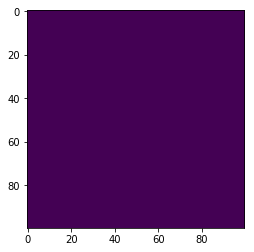

In [3]:
plt.imshow(np.squeeze(bb.X_train[12]))

In [4]:
Y_train[0].shape,Y_train[1].shape

((9018, 4), (9018, 4))

In [5]:
cnn_input=tf.keras.layers.Input( shape=bb.X_train.shape[1:] ) # Shape here does not including the batch size 
cnn_layer1=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_input) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer1) 

cnn_layer2=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_activation) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer2) 

#cnn_layer3=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_activation) 
#cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer3) 

flat=tf.keras.layers.Flatten()(cnn_activation) 
flat=tf.keras.layers.Dropout(0.5)(flat)

cat_output_layer=tf.keras.layers.Dense(4)(flat) 
cat_output=tf.keras.layers.Activation('softmax')(cat_output_layer)

bbox_output=tf.keras.layers.Dense(50)(flat) 
bbox_output=tf.keras.layers.LeakyReLU()(bbox_output)
bbox_output=tf.keras.layers.Dense(50)(bbox_output) 
bbox_output=tf.keras.layers.LeakyReLU()(bbox_output)

bbox_output=tf.keras.layers.Dense(4)(bbox_output) 

model=tf.keras.models.Model(cnn_input,[cat_output,bbox_output])

model.compile(loss=['categorical_crossentropy','mae'],
              optimizer='adam',
              metrics=[])
model.summary()

history=model.fit(bb.X_train, Y_train, 
          batch_size=32, epochs=25, verbose=1,
         validation_data=(bb.X_develop,Y_develop)
         )



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 50, 64)   1088        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 50, 50, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 25, 64)   65600       leaky_re_lu[0][0]                
__________________________________________________________________________________________________
leaky_re_l

KeyboardInterrupt: 

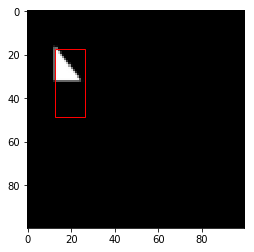

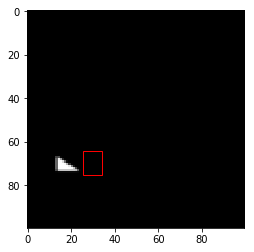

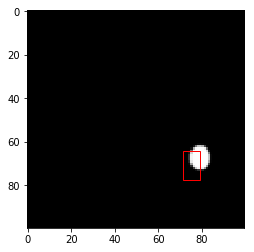

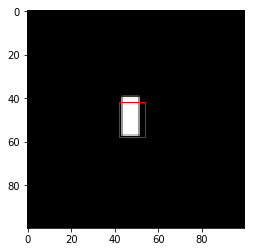

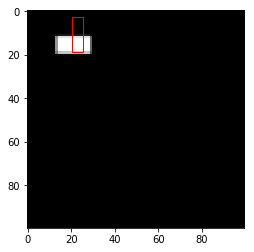

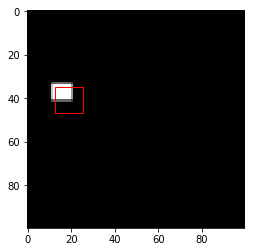

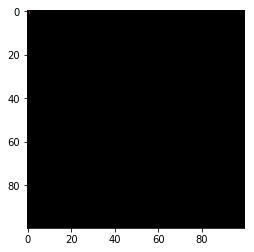

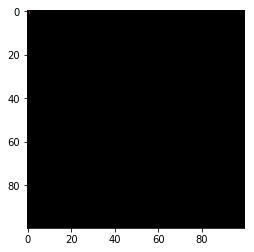

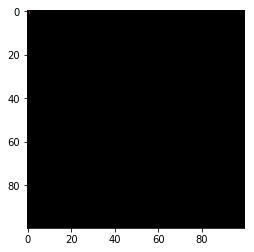

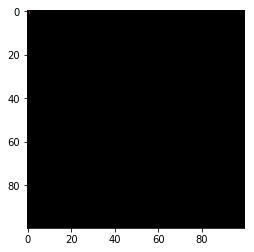

In [6]:


predictions=model.predict(bb.X_develop)

for i in range(10):    
    cat=np.argmax(predictions[0][i])
    bbox=[ [cat,[(predictions[1][i,0],predictions[1][i,1]),predictions[1][i,2],predictions[1][i,3]]]]
    plot_point(np.squeeze(bb.X_develop)[i],bbox)





## Identifying more than one thing at a time
np.isnan(array).any()



In [7]:
bb_multi=BBToyData(multi_object= True)
n_detectors=16



/home/jsearcy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [8]:


def get_labels(input_labels,n_detectors):
    Y_train=[[] for i in range(2*n_detectors)]

    for image_labels in input_labels:
        detected=[]
        for i,(cat,bbox) in enumerate(image_labels):
            bbox_center_x=(bbox[0][0]+bbox[1]/2.)//0.25
            bbox_center_y=(bbox[0][1]+bbox[2]/2.)//0.25
            detector_i=int(bbox_center_y*4+bbox_center_x)
            detected.append([detector_i,cat,bbox])
        for n in range(n_detectors):
            Y_train[2*n].append(3)
            b_x=0.25*(n%4)
            b_y=0.25*(n//4)
            Y_train[2*n+1].append(np.array([[b_x,b_y,.25,.25]]))
        for detector_i,cat,bbox in detected:
            Y_train[2*detector_i][-1]=cat
            Y_train[2*detector_i+1][-1]=[[bbox[0][0],bbox[0][1],bbox[1],bbox[2]]]
            
            
            
    for i in range(len(Y_train)):
        if i%2==0:
            Y_train[i]=tf.keras.utils.to_categorical(Y_train[i],4)
        else:
            Y_train[i]=np.concatenate(Y_train[i])
    return Y_train
Y_train=get_labels(bb_multi.Y_train,n_detectors=n_detectors)
Y_develop=get_labels(bb_multi.Y_develop,n_detectors=n_detectors)
Y_test=get_labels(bb_multi.Y_test,n_detectors=n_detectors)





In [9]:
print([q.shape for q in Y_train])

[(9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4), (9029, 4)]


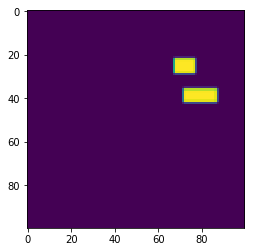

In [10]:

plt.imshow(np.squeeze(bb_multi.X_train[10]))

In [11]:
print(n_detectors)

cnn_input=tf.keras.layers.Input( shape=bb_multi.X_train.shape[1:] ) # Shape here does not including the batch size 
cnn_layer1=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_input) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer1) 

cnn_layer2=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_activation) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer2) 

cnn_layer3=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_activation) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer3) 

flat=tf.keras.layers.Flatten()(cnn_activation) 
flat=tf.keras.layers.Dropout(0.5)(flat)


detectors=[]
print(n_detectors)
for i in range(n_detectors):
    print(i)
    cat_output_layer=tf.keras.layers.Dense(4)(flat) 
    cat_output=tf.keras.layers.Activation('softmax')(cat_output_layer)

    
    bbox_output=tf.keras.layers.Dense(50)(flat) 
    bbox_output=tf.keras.layers.LeakyReLU()(bbox_output)
    bbox_output=tf.keras.layers.Dense(50)(bbox_output) 
    bbox_output=tf.keras.layers.LeakyReLU()(bbox_output)
    bbox_output=tf.keras.layers.Dropout(0.4)(bbox_output)
    bbox_output=tf.keras.layers.Dense(4)(bbox_output) 
    detectors.append(cat_output)
    detectors.append(bbox_output)
    
    
model=tf.keras.models.Model(cnn_input,detectors)

model.compile(loss=['categorical_crossentropy','mae']*n_detectors,
                  optimizer='adam',
                  metrics=[])
model.summary()




16
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 50, 50, 64)   1088        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 50, 50, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 25, 25, 64)   65600       leaky_re_lu_4[0][0]              
_________________________________________________________________

In [ ]:
history=model.fit(bb_multi.X_train, Y_train, 
        batch_size=32, epochs=50, verbose=1,
        validation_data=(bb_multi.X_develop,Y_develop)
                 )


Train on 9029 samples, validate on 8009 samples
Epoch 1/50
7232/9029 [=======================>......] - ETA: 7s - loss: 4.6572 - activation_1_loss: 0.1009 - dense_7_loss: 0.0518 - activation_2_loss: 0.1797 - dense_11_loss: 0.0639 - activation_3_loss: 0.1807 - dense_15_loss: 0.0820 - activation_4_loss: 0.0965 - dense_19_loss: 0.1070 - activation_5_loss: 0.1576 - dense_23_loss: 0.0702 - activation_6_loss: 0.3437 - dense_27_loss: 0.0777 - activation_7_loss: 0.3295 - dense_31_loss: 0.0973 - activation_8_loss: 0.1704 - dense_35_loss: 0.1071 - activation_9_loss: 0.1709 - dense_39_loss: 0.0860 - activation_10_loss: 0.3436 - dense_43_loss: 0.0953 - activation_11_loss: 0.3512 - dense_47_loss: 0.0967 - activation_12_loss: 0.1747 - dense_51_loss: 0.1249 - activation_13_loss: 0.0962 - dense_55_loss: 0.0998 - activation_14_loss: 0.1683 - dense_59_loss: 0.1130 - activation_15_loss: 0.1696 - dense_63_loss: 0.1138 - activation_16_loss: 0.0982 - dense_67_loss: 0.1388

In [ ]:
detector_predictions=model.predict(bb_multi.X_train)




In [ ]:
predictions=[]
for pred in range(len(detector_predictions[0])):
    labels=[]
    for i in range(n_detectors):
        cat=detector_predictions[2*i][pred]
        if np.argmax(cat)!=3:
            bbox= detector_predictions[2*i+1][pred]
            bbox=[(bbox[0],bbox[1]),bbox[2],bbox[3]]
            labels.append((np.argmax(cat),bbox))
    predictions.append(labels)

In [ ]:
[plot_point(np.squeeze(bb_multi.X_train[i]),predictions[i],bb_multi.Y_train[i]) for i in range(30)]     

## A Full Functional Algorigthms

SSD
